## Цель иследования
 - выявить частоту (периоды) повторяемости наблюдаемой характеристики 'rang_namber'
 - создать модель для ML позволяющую предиктить периоды на новых данных 
 - предположить факторы влияющие на чатсоту повторяемости
 - https://github.com/julianandrews/flopferret/blob/master/flopferret/board_texture.py

In [1]:
import re
import pandas as pd
from datetime import datetime
import eval7, pprint
from poker.room.pokerstars import PokerStarsHandHistory
from poker.hand import Hand, Combo
import numpy as np
from phevaluator import evaluate_cards
import matplotlib.pyplot as plt
plt.style.use('dark_background') #стиль графиков

In [2]:
# Создали словарь
data_pd = {'TypeOfRoom': [], 'HandId': [], 'Tournament': [], 'Level': [], 'Date': [], 'Hour': [],
           'TimeZoneAbb': [], 'Table': [], 'NoOfPlayers': [], 'bain': [], 'HandHiro': [], 'Board': []}

# Открываем файл
with open('Poker_\SNG dimetruk 1-54133.txt', 'r') as f: #Poker_\SNG dimetruk 1-54133.txt
    data = f.read()
    
# Ищем нужные данные
result = re.findall('(\w+) Hand #(\d*): Tournament #(\d*),(.*) Level (.*) - (\d{4}/\d+/\d+) (\d+\D\d+\D\d+) (\w*)', data)
Tables = re.findall('Table \'.*\' (.*) Seat .*\n', data)
bains = re.findall('(\D\d+\.\d+\+\D\d+\.\d+)', data)
HandHiros = re.findall("Dealt to dimetruk \D(.. ..)\D", data)
Boards = re.findall("Board \[(.*)\]", data)


# Считаем сколко фишек
s = re.findall('Seat (\d).*chips', data)
s = [int(x) for x in s]
seats = []
length = 1
for i in range(len(s)-1):
    if s[i+1] < s[i]:
        seats.append(length)
        length = 1
    else:
        length += 1
seats.append(length)


# ЗАполнЯем словарь данными
for r, table, bain, seat, handHiro, board in zip(result, Tables, bains, seats, HandHiros, Boards):
    data_pd['TypeOfRoom'].append(r[0])
    data_pd['HandId'].append(r[1])
    data_pd['Tournament'].append(r[2])
    # data_pd['info'].append(r[3])
    data_pd['Level'].append(r[4])
    data_pd['Date'].append(r[5])
    data_pd['Hour'].append(r[6])
    data_pd['TimeZoneAbb'].append(r[7])
    data_pd['Table'].append(table) #table
    data_pd['NoOfPlayers'].append(seat)
    data_pd['bain'].append(bain)
    data_pd['HandHiro'].append(handHiro)
    data_pd['Board'].append(board)

# Создаём ДатаФрейм
dataf = pd.DataFrame(data_pd)
dataf.head()

,TypeOfRoom,HandId,Tournament,Level,Date,Hour,TimeZoneAbb,Table,NoOfPlayers,bain,HandHiro,Board
0,PokerStars,189303406555,2369603774,IV (40/80),2018/07/30,0:01:30,MSK,9-max,6,$13.70+$1.30,Qh 6h,8h 7d 2h 8c 4s
1,PokerStars,189303615886,2369603774,V (60/120),2018/07/30,0:05:40,MSK,9-max,6,$13.70+$1.30,Qc Td,Qh 5h Js Kd
2,PokerStars,189303670340,2369603774,V (60/120),2018/07/30,0:06:42,MSK,9-max,6,$13.70+$1.30,Ac 7d,2d Ad Ah Js 6s
3,PokerStars,189303726585,2369603774,V (60/120),2018/07/30,0:07:47,MSK,9-max,6,$13.70+$1.30,Tc Qc,Td 5h 2c 5d Kd
4,PokerStars,189303781865,2369603774,V (60/120),2018/07/30,0:08:51,MSK,9-max,6,$13.70+$1.30,Qs 5d,9s 7h Jh 8h 9d


## Преобразуем строковые данные

In [3]:
date = data_pd['Date']
time = data_pd['Hour']

dataf["Date"] = pd.to_datetime(data_pd['Date'])
dataf["Time"] = pd.to_timedelta(data_pd['Hour'])

dataf["DateTime"] = dataf["Date"] + dataf["Time"]
dataf["DateTime"]

# filter by single day
dataf_m = dataf[dataf['DateTime'].dt.strftime('%d') == '06']

dataf.Tournament = dataf.Tournament.astype('int64')
dataf = dataf.astype({'HandId': np.int64, 'Tournament': np.int64})

In [4]:
# dataf["Date"]

In [5]:
# дневной период  https://askdev.ru/q/kak-gruppirovat-i-podschityvat-stroki-po-mesyacam-i-godam-s-pomoschyu-pand-511317/
# df_day = dataf['DateTime'].groupby(dataf.DateTime.dt.to_period("D")).agg('count')
# df_day

In [6]:
# # Получим разницу между датами в днях    https://habr.com/ru/company/wunderfund/blog/677068/
# df["days_to_checkin"] = \
# (df["checkin_date"] - df["created_at"]).dt.days
# # вывод объекта DataFrame
# df

In [7]:
# nov_mar_series = pd.Series(pd.date_range("2013-11-15", "2014-03-15"))
# #create timestamp without year
# nov_mar_no_year = nov_mar_series.map(lambda x: x.strftime("%m-%d"))
# nov_mar_no_year

In [8]:
# #add a yearless timestamp to the dataframe
# df["no_year"] = df['nov_mar_series'].map(lambda x: x.strftime("%m-%d"))
# no_year_mask = df['no_year'].isin(nov_mar_no_year)
# df[no_year_mask]

## Фильтруем турниры 

In [9]:
data_filter = dataf[['Date', 'HandHiro', 'Board']]
data_filter.head()

,Date,HandHiro,Board
0,2018-07-30,Qh 6h,8h 7d 2h 8c 4s
1,2018-07-30,Qc Td,Qh 5h Js Kd
2,2018-07-30,Ac 7d,2d Ad Ah Js 6s
3,2018-07-30,Tc Qc,Td 5h 2c 5d Kd
4,2018-07-30,Qs 5d,9s 7h Jh 8h 9d


In [10]:
# data_filter.groupby(['Tournament']).agg({'HandId': "count"}).reset_index()

In [11]:
#  Фильтруйте value_counts с помощью isin  https://softhints.com/pandas-how-to-filter-results-of-value_counts/
# data_filter[data_filter['Tournament'].isin(data_filter['Tournament'].value_counts()[data_filter['Tournament'].value_counts()>30].index)].Tournament


In [12]:
#  Используйте group by и lambda для имитации фильтра для value_counts()
# df = data_filter.groupby('Tournament').filter(lambda x: len(x) > (data_filter['Tournament'].value_counts().mean()))
# df

In [13]:
#df.Tournament.value_counts()

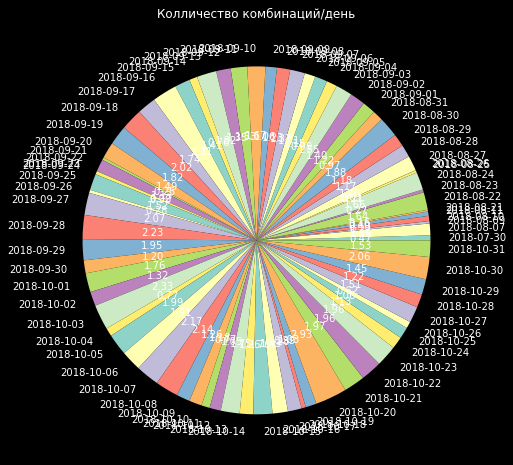

In [14]:
# Prepare Data
# df_plot = df_day.groupby('DateTime').size()
df_plot=dataf['DateTime'].groupby(dataf.DateTime.dt.to_period("D")).agg('count')

# Make the plot with pandas
df_plot.plot(kind='pie', subplots=True,autopct="%.2f", figsize=(8, 8))
plt.title("Колличество комбинаций/день")
plt.ylabel("")
plt.show()

In [15]:
# объеденяем руку и борд, выводим название комбинации

# df['hand'] = df['HandHiro'] + " " + df['Board']
# # hand = df['hand'].values[7].split()
# # print(hand)

# hand_ev = [eval7.Card(s) for s in (df['hand'].values[7].split())]
# rang = eval7.evaluate(hand_ev)   # ранг комбинации
# # print(rang)

# eval7s = eval7.handtype(rang)  #  название комбинации

# df['rang'] = eval7.evaluate(hand_ev)
# df['eval7s'] =  eval7.handtype(rang)

In [16]:
# def new_type(row):
#     if row.traffic_source.lower() in ('yandex', 'google'):
#         return 'organic'
#     elif row.traffic_source.lower() in ('paid', 'email'):
#         if row.region.lower() == 'russia':
#             return 'ad'
#         else:
#             return 'other'

In [17]:
# log['source_type'] = log.apply(new_type, axis = 1)
# log.head(12)

In [18]:
# log.loc[log.traffic_source.isin(['yandex', 'google']), 'traffic_type'] = 'organic' 

In [19]:
df = dataf

df['hand_rang'] = df['HandHiro'] + " " + df['Board']
df['hand_rang']

print(type(df['hand_rang']), type(df['hand_rang'].values[7].split()))
df['hand_rang'].values[0].split()

<class 'pandas.core.series.Series'> <class 'list'>


['Qh', '6h', '8h', '7d', '2h', '8c', '4s']

In [20]:
# df['hand_rang'].to_list()
# df['hand_rang'].tolist()
# np.array(df['hand_rang'].tolist())
# Ls = list(df['hand_rang'])
ls = df['hand_rang'].str.split()
ls

0        [Qh, 6h, 8h, 7d, 2h, 8c, 4s]
1            [Qc, Td, Qh, 5h, Js, Kd]
2        [Ac, 7d, 2d, Ad, Ah, Js, 6s]
3        [Tc, Qc, Td, 5h, 2c, 5d, Kd]
4        [Qs, 5d, 9s, 7h, Jh, 8h, 9d]
                     ...             
54128    [3c, 7s, 5s, 7d, 5h, Ts, Qd]
54129    [Qc, Kc, 2d, 7c, 7s, 8h, 4h]
54130            [9s, 9c, 2c, 4c, 7d]
54131    [4s, 4d, 2h, 5c, Qh, 6c, Jd]
54132    [Qc, Ac, 4c, 9c, Tc, Kd, Qs]
Name: hand_rang, Length: 54133, dtype: object

In [21]:
# напишем функцию получения ранг комбинации

def evaluate_(hand):
    """
    На вход получает карты, на выход 
    число ранг по eval7
    """
    hand_ev = [eval7.Card(s) for s in (hand)]
    return eval7.evaluate(hand_ev)

a = ('Jh', 'Td', '8h', '8c', '7c', '3h', '6d')
evaluate_(a)

17209424

In [22]:
# напишем функцию получения названия ранга

def handtype_(rang):
    """
    На вход получает ранг, на выход 
    название комбинации
    """
    return eval7.handtype(rang)

handtype_(17209424)

'Pair'

In [23]:
# Применим функцию к столбцу hand  и запишем в новый столбец rang_namber

df['rang_namber'] = df['hand_rang'].str.split().apply(evaluate_)
df['handtypes'] = df['rang_namber'].apply(handtype_)
df = df[['Date', 'handtypes', 'rang_namber']]
df.head()
# df['filter'] = df.loc[df.handtypes.str.contains('Two Pair', 'Trips', 'Straight', 'Full House', 'Quads', 'Straight Flush'), 'rang_namber']

,Date,handtypes,rang_namber
0,2018-07-30,Pair,17212736
1,2018-07-30,Pair,17480064
2,2018-07-30,Trips,51156224
3,2018-07-30,Two Pair,34093824
4,2018-07-30,Pair,17279328


In [24]:
# df.sort_values(by=['handtypes', 'rang_namber'])

In [25]:
# df.groupby('handtypes')['rang_namber'].value_counts()

### Создадим сводную таблицу, что-бы проверить наличие аномалий

In [26]:
# df_mylty = pd.MultiIndex.from_frame(df)
# df_mylty

In [27]:
# df.reindex(df_mylty)    

In [28]:
# df_pivot = pd.pivot_table(df, index=["Date", "handtypes"],
#                           values=["rang_namber"],
#                           aggfunc= len)
# df_pivot

In [29]:
# df_mylty = pd.MultiIndex.from_frame(df_pivot)
# df_mylty

In [30]:
df_raw = df.groupby([df.Date.dt.to_period("M"), "handtypes"])['rang_namber'].count()
df_raw

Date     handtypes     
2018-07  Flush                 9
         Full House            2
         High Card            70
         Pair                118
         Straight              4
         Straight Flush        1
         Trips                17
         Two Pair             32
2018-08  Flush               126
         Full House          108
         High Card          2173
         Pair               2908
         Quads                 5
         Straight            210
         Trips               300
         Two Pair           1066
2018-09  Flush               381
         Full House          346
         High Card          6657
         Pair               9263
         Quads                29
         Straight            615
         Straight Flush        5
         Trips               843
         Two Pair           3425
2018-10  Flush               470
         Full House          404
         High Card          7929
         Pair              10880
         Quads     

In [31]:
# дневной период  https://askdev.ru/q/kak-gruppirovat-i-podschityvat-stroki-po-mesyacam-i-godam-s-pomoschyu-pand-511317/
df_day = dataf['DateTime'].groupby(dataf.DateTime.dt.to_period("D")).agg('count')
df_day

DateTime
2018-07-30     253
2018-08-07     588
2018-08-09     119
2018-08-10     259
2018-08-11     217
              ... 
2018-10-27     815
2018-10-28     661
2018-10-29     786
2018-10-30    1117
2018-10-31     829
Freq: D, Name: DateTime, Length: 77, dtype: int64

In [32]:
# явно определив столбцы, которые нам нужны,
pd.pivot_table(df,
               index=[ "handtypes","Date"],
               values=["rang_namber"],
               aggfunc= len)  # aggfunc=[np.mean, len])

rang_namber
handtypes Date                   
Flush     2018-07-30            9
          2018-08-07           11
          2018-08-09            1
          2018-08-10            1
          2018-08-11            6
...                           ...
Two Pair  2018-10-27          120
          2018-10-28           83
          2018-10-29          132
          2018-10-30          168
          2018-10-31          142

[574 rows x 1 columns]

In [33]:
df['Date'].value_counts()

2018-10-20    1584
2018-10-03    1263
2018-09-16    1249
2018-09-28    1206
2018-10-07    1174
              ... 
2018-08-09     119
2018-08-25     115
2018-08-21      85
2018-09-23      11
2018-08-26       8
Name: Date, Length: 77, dtype: int64

In [34]:
# df['Time'].value_counts()

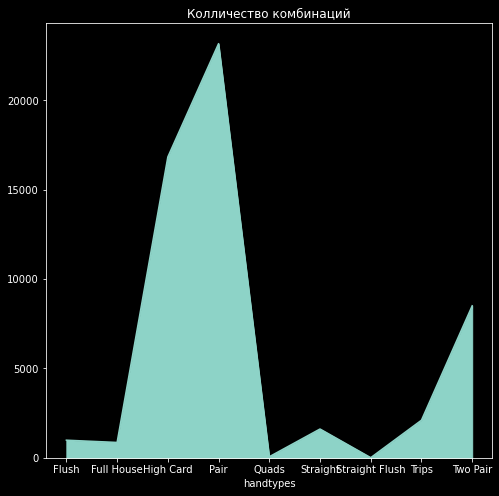

In [35]:
# Prepare Data
df_plot = df.groupby('handtypes').size()

# Make the plot with pandas
df_plot.plot(kind='area', subplots=True, figsize=(8, 8))
plt.title("Колличество комбинаций")
plt.ylabel("")
plt.show()

In [36]:
# df['DateTime'] = df['DateTime'][(df['DateTime'] > '2018-10-01 20:00:00') & (df['DateTime'] < '2022-10-02 00:00:00')]
# df['DateTime']


In [37]:
# отфильтруем комбинации "старшая карта" и "пара"
df['no_par'] = df['rang_namber'][df['rang_namber'] > 50000000] #[((df['rang_namber'] > 50000000) & (df['rang_namber'] < 60000000))]
df = df.dropna()
df[['Time', 'no_par', 'handtypes']].head(10)
# df['filter_Two Pair'] = df['handtypes'][df['handtypes'] == 'Two Pair']
# df['filter_Two Pair']

C:\Users\artio\AppData\Local\Temp/ipykernel_23556/4226328600.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no_par'] = df['rang_namber'][df['rang_namber'] > 50000000] #[((df['rang_namber'] > 50000000) & (df['rang_namber'] < 60000000))]


KeyError: "['Time'] not in index"

In [ ]:
df.isnull().sum()

In [ ]:
# преобразуем время во временной ряд


In [ ]:


idx = df['Time']
 # datetime.timedelta(seconds=24*60*60).total_seconds()

# second = df['DateTime'].dt.total_seconds()
# second

# idx = pd.date_range(df['DateTime'], periods=5, freq="H")
# idx
tim = pd.Series(range(len(idx)), index=idx)

# ts.resample("2H").mean()
tim

In [ ]:
# df = df.set_index("Time")
# df

In [ ]:

import matplotlib.pyplot as plt
 
# Using a inbuilt style to change
# the look and feel of the plot
plt.style.use("classic")
 
# setting figure size to 12, 10
plt.figure(figsize=(12, 10))
 
# Labelling the axes and setting
# a title
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Sample Time Series Plot")
 
# plotting the "A" column alone
plt.plot(df["handtypes"])

In [ ]:
df.plot(subplots=True, figsize=(12, 15))

In [ ]:
# # # idx = pd.date_range('2019-01-01', periods=48, freq='H')
# # x = pd.Series(range(len(idx)), index=idx)
# y = tim
# # add 'hour' and 'day' columns in the dataframe
# d = {'x': x, 'y': y, 'hour': idx.hour, 'day': idx.day}
# df = pd.DataFrame(data=d)
# # use 'hour' as x axis to plot, and 'day' as marker color
# df.plot.scatter(x='hour', y='y', c='day', colormap='rainbow')
# plt.show()

In [ ]:
data.dtypes

In [ ]:
# установитьdatetimeОбъект в качестве индекса кадра данных
data = data.set_index('DateTime')
data.head()

In [ ]:

# data.plot(grid=True)

data['filter'].plot(kind='bar')

# import matplotlib.pyplot as plt
# from matplotlib.dates import DateFormatter
# # Группировка за месяц
# df_month = data.resample("M").mean()

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
# ax.bar(
#     df_month['2018':].index, 
#     df_month.loc['2016':, "filter"], 
#     width=25, align='center')

In [ ]:

data.plot(kind='scatter', 
        x='DateTime', 
        y='filter', 
        title='Связь между жёсткостью воды и средней годовой смертностью')